In [15]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.python.keras.models import Model
import tensorflow as tf
import pathlib

Shape of the image (1890,)


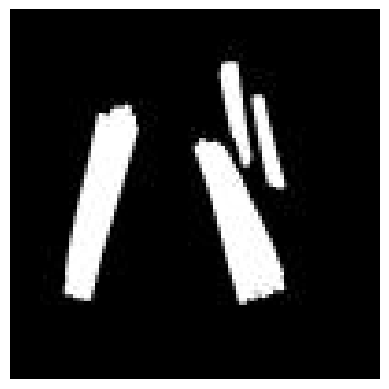

Shape of the image (2268,)


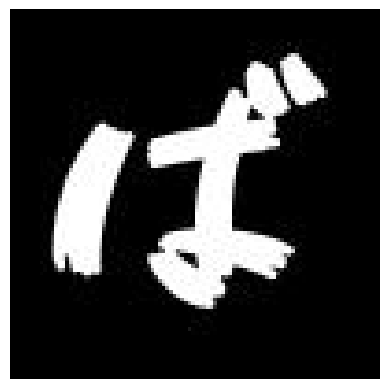

In [11]:
url_kata = r'https://github.com/Orzelius/7500-unique-kana-images/blob/master/katakana/ba_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg?raw=true'
resp = requests.get(url_kata, stream=True).raw
image_array_baKata = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_baKata.shape}')
image_baKata = cv2.imdecode(image_array_baKata, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_baKata, cv2.COLOR_BGR2RGB))
plt.show()

url_hira = r'https://github.com/Orzelius/7500-unique-kana-images/blob/master/hiragana/ba_851CHIKARA-DZUYOKU-KANA-A_dakutrue.jpeg?raw=true'
resp = requests.get(url_hira, stream=True).raw
image_array_baHira = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_baHira.shape}')
image_baHira = cv2.imdecode(image_array_baHira, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_baHira, cv2.COLOR_BGR2RGB))
plt.show()

(40, 40, 3)
(40, 40)


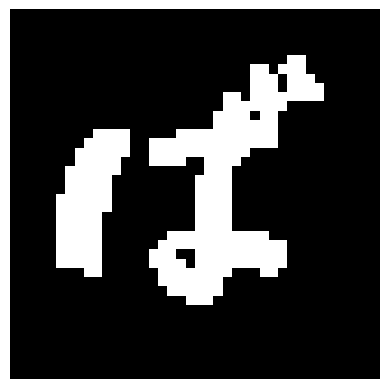

In [13]:
res = cv2.resize(image_baHira , dsize=(40,40), interpolation=cv2.INTER_CUBIC)
print(res.shape)
res = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY) #TO 3D to 1D
print(res.shape)
res = cv2.threshold(res, 127, 255, cv2.THRESH_BINARY)[1]
d = res

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [22]:
dataDir = pathlib.Path("dataset/katakanaSeparated/")
validDir = pathlib.Path("dataset/katakanaValidationSeparated/")
print(dataDir)

dataset/katakanaSeparated


In [20]:
batchSize = 32
imgHeight = 100
imgWidth = 100

In [23]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize,
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validDir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize,
)

class_names = val_data.class_names
print(class_names)

Found 3376 files belonging to 67 classes.
Using 2701 files for training.
Found 376 files belonging to 67 classes.
Using 75 files for validation.
['ba', 'be', 'bi', 'bo', 'bu', 'da', 'de', 'di', 'do', 'du', 'ga', 'ge', 'gi', 'go', 'gu', 'ha', 'he', 'hi', 'ho', 'hu', 'ka', 'ke', 'ki', 'ko', 'ku', 'ma', 'me', 'mi', 'mo', 'mu', 'na', 'ne', 'ni', 'no', 'nu', 'pa', 'pe', 'pi', 'po', 'pu', 'ra', 're', 'ri', 'ro', 'ru', 'sa', 'se', 'si', 'so', 'su', 'ta', 'te', 'ti', 'to', 'tu', 'wa', 'wo', 'wu', 'ya', 'yi', 'yo', 'yu', 'za', 'ze', 'zi', 'zo', 'zu']


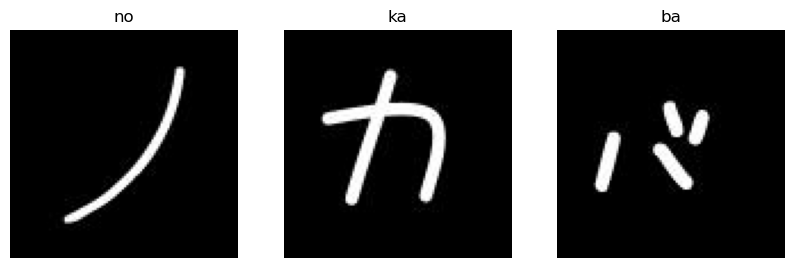

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")